In [20]:
library(ggplot2)
library(dplyr)
library(tibble)

In [21]:
bookings <- read.csv(file='hotel_bookings.csv')

In [22]:
head(bookings)

hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NULL,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03
Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03


In [23]:
bookings <-bookings  %>% select(-c('reservation_status', 'reservation_status_date'))

In [24]:
months <- data.frame(month=c("January", "February", "March","April","May",
  "June","July","August","September","October","November","December"), month_num=c(1:12))

month_num <- bookings  %>% 
    transmute(month=arrival_date_month)  %>% 
    left_join(months)  %>% 
    select(month_num)

bookings$arrival_date_month <- month_num$month_num

Joining, by = "month"


In [25]:
bookings$country <- (bookings  %>% select(country) %>% replace(is.na(.), 'NAN'))$country

bookings <- bookings %>% mutate_if(is.integer, as.numeric)

### Visualisation country / cancellation rate

In [26]:
bookings  %>% 
    group_by(country)  %>% 
    summarise(n=n(), cancellation_rate=1-mean(is_canceled))  %>% 
    filter(n > 700)  %>% 
    arrange(-cancellation_rate)  


`summarise()` ungrouping output (override with `.groups` argument)


country,n,cancellation_rate
DEU,7287,"0,8328530"
AUT,1263,"0,8178939"
NLD,2104,"0,8160646"
FRA,10415,"0,8143063"
CN,1279,"0,8014073"
GBR,12129,"0,7977574"
BEL,2342,"0,7976089"
SWE,1024,"0,7783203"
POL,919,"0,7660501"
USA,2097,"0,7610873"


`summarise()` ungrouping output (override with `.groups` argument)


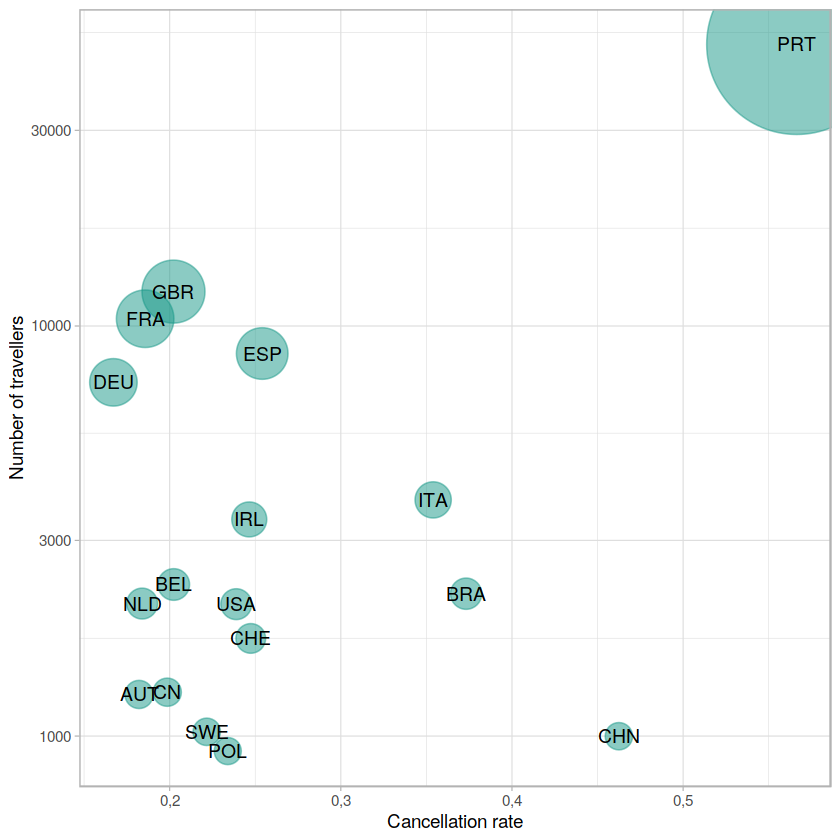

In [27]:
bookings  %>% 
    group_by(country)  %>% 
    summarise(n=n(), cancellation_rate=mean(is_canceled))  %>% 
    filter(n > 700)  %>% 
    arrange(-cancellation_rate)   %>% 
    ggplot(aes(x=cancellation_rate, y=n, size=n, label=country)) + 
    geom_point(alpha=0.5, color='#199888', show.legend = FALSE) +
    scale_radius(range = c(7,50), labels=NULL) + geom_text(size=4) + 
    scale_y_log10() +
    xlab("Cancellation rate") + ylab('Number of travellers') +
    theme_light()


### Classification

In [28]:
library(randomForest) 

#install.packages("randomForest")

In [29]:
bookings$is_canceled <- as.factor(bookings$is_canceled)

bookings$children[is.na(bookings$children)] <- 0 

In [30]:
sapply(bookings, class)

hotel                    is_canceled 
                      "factor"                       "factor" 
                     lead_time              arrival_date_year 
                     "numeric"                      "numeric" 
            arrival_date_month       arrival_date_week_number 
                     "numeric"                      "numeric" 
     arrival_date_day_of_month        stays_in_weekend_nights 
                     "numeric"                      "numeric" 
          stays_in_week_nights                         adults 
                     "numeric"                      "numeric" 
                      children                         babies 
                     "numeric"                      "numeric" 
                          meal                        country 
                      "factor"                       "factor" 
                market_segment           distribution_channel 
                      "factor"                       "factor" 
             is_repeated_guest         previous_cancellations 
                     "numeric"                      "numeric" 
previous_bookings_not_canceled             reserved_room_type 
                     "numeric"                       "factor" 
            assigned_room_type                booking_changes 
                      "factor"                      "numeric" 
                  deposit_type                          agent 
                      "factor"                       "factor" 
                       company           days_in_waiting_list 
                      "factor"                      "numeric" 
                 customer_type                            adr 
                      "factor"                      "numeric" 
   required_car_parking_spaces      total_of_special_requests 
                     "numeric"                      "numeric"

In [31]:
# Some categorical features have too many unique values, randomForest library doesn't like it
# therefore we leave only 10 most common values, and replace the rest with "other"

most_common_agents <- bookings  %>% 
    group_by(agent)  %>% 
    summarise(n=n())  %>% 
    top_n(10, wt=n)  %>% 
    select(agent)

bookings <- mutate(bookings, agent=ifelse(agent %in% most_common_agents$agent, agent, 'other'))

most_common_companies <- bookings  %>% 
    group_by(company)  %>% 
    summarise(n=n())  %>% 
    top_n(10, wt=n)  %>% 
    select(company)

bookings <- mutate(bookings, company=ifelse(company %in% most_common_companies$company, company, 'other'))

most_common_countries <- bookings  %>% 
    group_by(country)  %>% 
    summarise(n=n())  %>% 
    top_n(10, wt=n)  %>% 
    select(country)

bookings <- mutate(bookings, country=ifelse(country %in% most_common_countries$country, country, 'other'))

bookings$country <- as.factor(bookings$country)
bookings$agent <- as.factor(bookings$agent)
bookings$company <- as.factor(bookings$company)

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


#### Split data into train/test

In [32]:
set.seed(42)

train_size = 0.8
train_idx <- sample(1:nrow(bookings), size=round(nrow(bookings) * train_size))
    
train <- bookings[train_idx,] 
test <- bookings[-train_idx,] 

#### Build the model and assess its performance

In [33]:
model <- randomForest(is_canceled ~ ., data=select(bookings, everything()), ntree=100, mtry=2, importance=TRUE)

In [34]:
predicted <- predict(model, test)
confusion_matrix <- table(observed=test$is_canceled, predicted=predicted)

In [35]:
#Accuracy
round(mean(predicted == test$is_canceled), 3)

[1] 0,89

In [36]:
round(confusion_matrix / length(predicted), 2)

        predicted
observed    0    1
       0 0,61 0,02
       1 0,09 0,28

#### Plot feature importances calculated by randomForest

Selecting by MeanDecreaseGini


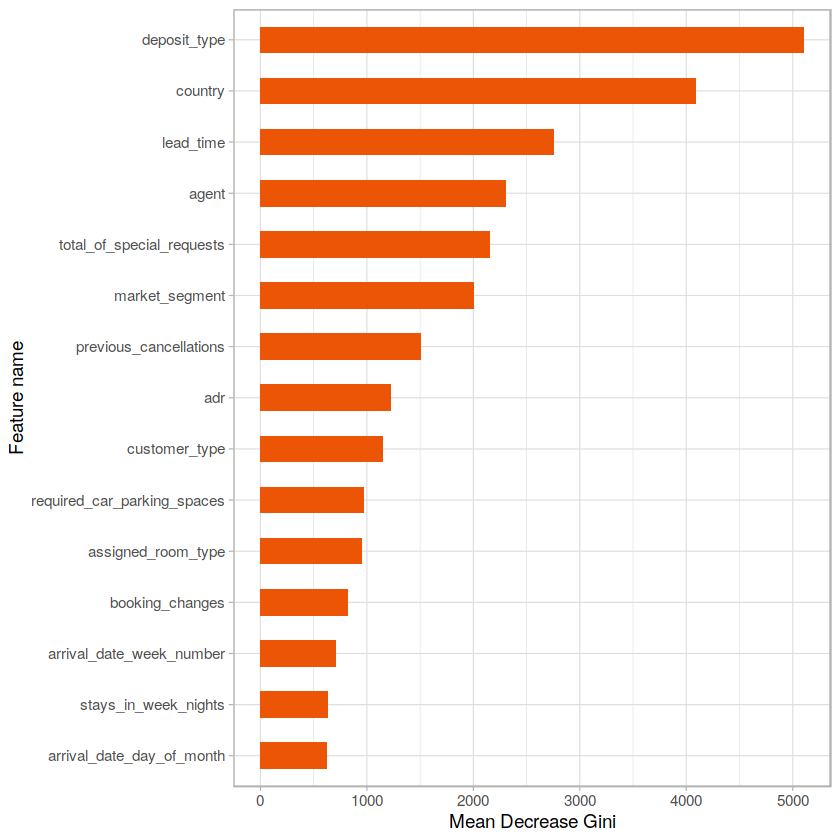

In [37]:
data.frame(importance(model))  %>% 
    select(MeanDecreaseGini)   %>% 
    rownames_to_column('feature')  %>% 
    arrange(-MeanDecreaseGini)  %>% 
    top_n(15)  %>% 
    ggplot() + geom_bar(aes(x=MeanDecreaseGini, y=reorder(feature, MeanDecreaseGini)), 
                        stat='identity', fill='#eb5505', width=0.5) +
    xlab('Mean Decrease Gini') + ylab('Feature name') +
    theme_light()